<a href="https://colab.research.google.com/github/TiantianWang-Sara/Machine-Learning-Projects/blob/main/Project_3_Stochastic_Cake_Eating_with_Portfolio_Choice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Due Date: November 20, 2024**

Consider the Stochastic Cake Eating Problem covered in class. Suppose that instead of investing the wealth entirely in the stock market, you have the option to assign a fraction $\alpha$ of your wealth in the stock market, and the remaining is invested in a risk-free savings account that pays a 1.04 % gross return. Notice that $\alpha$ is bounded below by 0, and bounded above by 1.

Solve for the optimal consumption ($c$) and asset allocation ($\alpha$).

- Print the average sum of discounted rewards (utilities) using 1 million simulations.

 - Plot the average consumption-wealth ratio ($c / x)$ for each time period $t=0, 1, ..., 299$

 - Plot the average asset allocation in the risky asset($\alpha)$ for each time period $t=0, 1, ..., 299$


In [ ]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import optax

In [ ]:
# Parameters
rng = jax.random.PRNGKey(0)
x0 = 10
T = 300
β = 0.95
Rf = 1.04
batch_size = 100 # Train Size
optimizer = optax.adam(-1e-2)
theta = jnp.array([[0.5, 0.5]]*T)
opt_state = optimizer.init(theta)

In [ ]:
# Define Function
def U(C, gamma):
    return C**(1-gamma)/(1-gamma)

def C_and_alpha(x: int, theta):
    theta1 = jax.nn.sigmoid(theta[0])
    theta2 = jax.nn.sigmoid(theta[1])
    C = theta1 * x
    risk_asset = theta2 * (x-C)
    return C, risk_asset

def stock_return(rng):
  μs = 0.06
  σs = 0.2
  ε = jax.random.normal(rng)
  log_return = μs + σs * ε
  return jnp.exp(log_return)

@jax.jit
def L(theta, rng):
  def one_simulation(rng):
    rng_t = jax.random.split(rng, T)
    x = x0
    V = 0.

    carry = x, V
    inputs = jnp.arange(300), rng_t,theta

    def core(carry, inputs):
      x, V = carry
      t, rng_t, theta = inputs
      ct, risk_asset = C_and_alpha(x, theta)
      cx = ct / x
      alpha = risk_asset / (x-ct)
      ut = U(ct, 2)

      V = V + ut * β**t
      R = stock_return(rng_t)
      x = risk_asset * R + (x-risk_asset) * Rf

      return (x, V), (cx, alpha)

    (x, V), ct_and_alpha = jax.lax.scan(core, carry, inputs)
    return V, ct_and_alpha

  rng_s = jax.random.split(rng, batch_size)
  V, ct_and_alpha = jax.vmap(one_simulation)(rng_s)
  ct = ct_and_alpha[0].mean(0)
  alpha = ct_and_alpha[1].mean(0)
  return V.mean(), (ct, alpha)

@jax.jit
def update(theta, opt_state, rng):
  rng, subrng = jax.random.split(rng)
  grad, _ = jax.grad(L, has_aux=True)(theta, rng)
  updates, opt_state = optimizer.update(grad, opt_state)
  theta = optax.apply_updates(updates, theta)
  return theta, opt_state, rng

In [ ]:
for iteration in range(10000):
  theta, opt_state, rng = update(theta, opt_state, rng)

In [ ]:
# Test Ct and Alpha using 1 million simulations
batch_size = 1000000
ct = L(theta, rng)[1][0]
alpha = L(theta, rng)[1][1]
L(theta, rng)[0]

Array(-1.1556143, dtype=float32)

In [ ]:
ct

Array([0.99991477, 0.9999143 , 0.9999146 , 0.99991524, 0.9999146 ,
       0.99991673, 0.999917  , 0.9999167 , 0.9999196 , 0.99991894,
       0.99991894, 0.9999208 , 0.99992   , 0.9999199 , 0.9999216 ,
       0.9999206 , 0.999922  , 0.999922  , 0.9999235 , 0.9999244 ,
       0.99992293, 0.9999237 , 0.999924  , 0.9999259 , 0.99992675,
       0.99992675, 0.99992704, 0.9999284 , 0.9999272 , 0.99992734,
       0.9999288 , 0.9999294 , 0.9999307 , 0.9999304 , 0.99993056,
       0.99993   , 0.99993163, 0.9999325 , 0.99993193, 0.99993134,
       0.9999339 , 0.99993336, 0.9999334 , 0.9999324 , 0.99993485,
       0.99993587, 0.99993765, 0.9999347 , 0.99993545, 0.9999364 ,
       0.99993545, 0.99993676, 0.99993765, 0.9999368 , 0.9999383 ,
       0.99993706, 0.9999382 , 0.9999379 , 0.9999397 , 0.99994004,
       0.99994016, 0.99994016, 0.9999402 , 0.99993926, 0.99993986,
       0.9999406 , 0.999942  , 0.9999413 , 0.9999415 , 0.9999415 ,
       0.9999423 , 0.9999415 , 0.9999418 , 0.999942  , 0.99994

In [ ]:
alpha

Array([0.98619   , 0.98742294, 0.98596203, 0.98635036, 0.9867445 ,
       0.98447067, 0.9856268 , 0.98632324, 0.98560333, 0.9865405 ,
       0.98653305, 0.98549473, 0.986311  , 0.9867863 , 0.98668015,
       0.9880058 , 0.9875873 , 0.9869432 , 0.9861069 , 0.98621196,
       0.98692733, 0.9873863 , 0.9864183 , 0.98718995, 0.9867362 ,
       0.9870004 , 0.98632795, 0.98654586, 0.9883694 , 0.98744094,
       0.9865768 , 0.9865318 , 0.9846437 , 0.9862358 , 0.9867407 ,
       0.9878547 , 0.9862709 , 0.9861433 , 0.98515654, 0.9881401 ,
       0.986138  , 0.98757714, 0.9869912 , 0.9872878 , 0.98597443,
       0.98699445, 0.9849173 , 0.98591536, 0.98713064, 0.98622656,
       0.986996  , 0.9873155 , 0.9858964 , 0.98651457, 0.98549825,
       0.9865737 , 0.98542446, 0.9876164 , 0.9871355 , 0.98645717,
       0.98574036, 0.9873936 , 0.9857661 , 0.9877014 , 0.98675215,
       0.9865187 , 0.9837863 , 0.98436946, 0.98659736, 0.9852313 ,
       0.98429805, 0.9853505 , 0.98448163, 0.9855949 , 0.98444

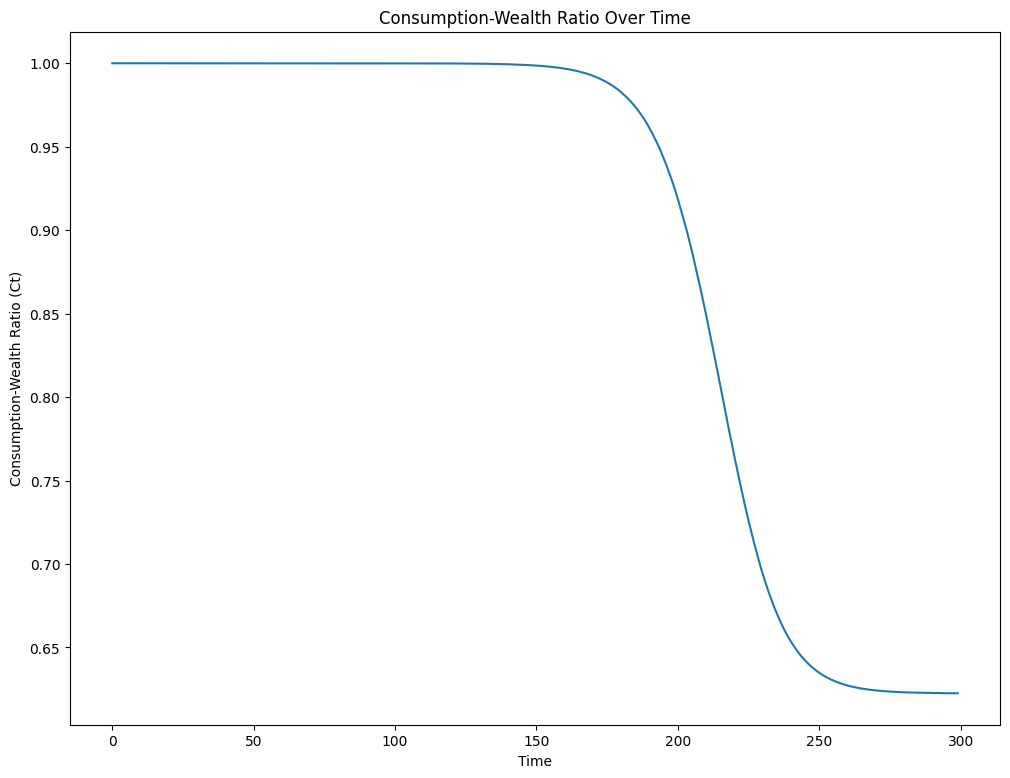

In [ ]:
# Plot of Ct
plt.figure(figsize=(12, 9))
plt.plot(ct)
plt.xlabel('Time')
plt.ylabel('Consumption-Wealth Ratio (Ct)')
plt.title('Consumption-Wealth Ratio Over Time')
plt.show()

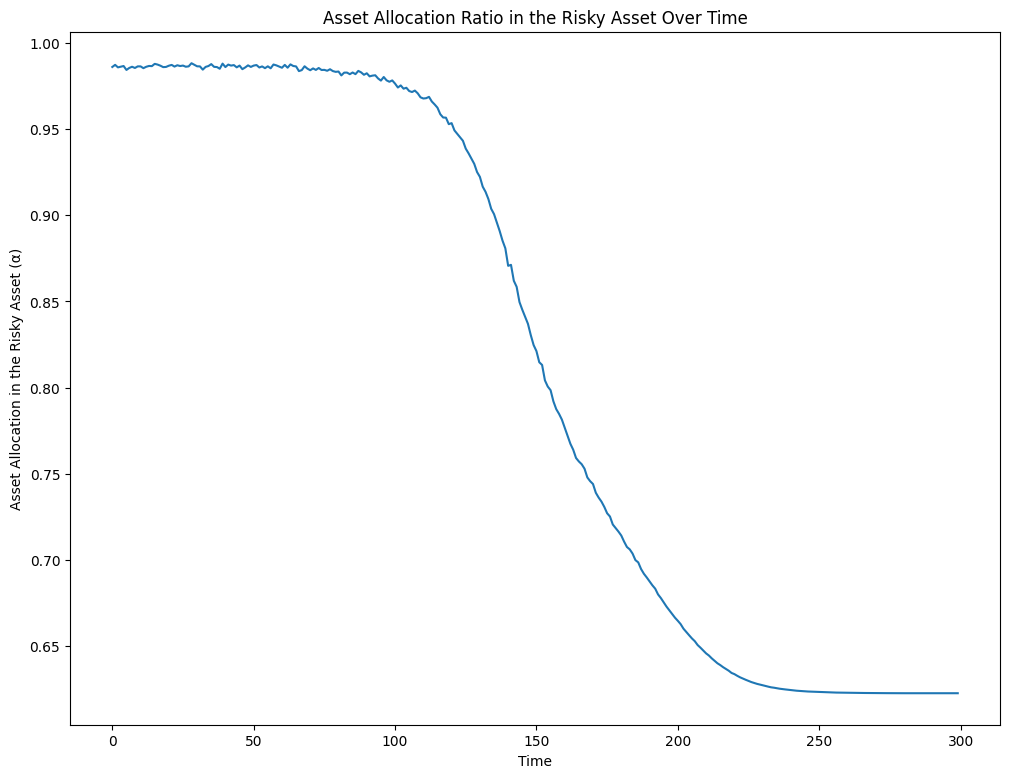

In [ ]:
# Plot of Alpha
plt.figure(figsize=(12, 9))
plt.plot(alpha)
plt.xlabel('Time')
plt.ylabel('Asset Allocation in the Risky Asset (α)')
plt.title('Asset Allocation Ratio in the Risky Asset Over Time')
plt.show()